In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import copy
import random

def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class SimpleMLP(nn.Module):
    """Simple MLP for demonstration with 20-dimensional input"""
    def __init__(self, input_size=20, hidden_size=64, output_size=1, seed=42):
        super(SimpleMLP, self).__init__()
        # Set seed before initializing layers for reproducible weights
        set_seed(seed)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

class LossLandscapeVisualizer:
    def __init__(self, model, loss_fn, data_loader):
        self.model = model
        self.loss_fn = loss_fn
        self.data_loader = data_loader
        self.device = next(model.parameters()).device

    def get_pca_directions(self, weight_trajectory):
        """Generate PCA directions from the optimization trajectory using [θ0−θn; · · · ; θn−1−θn] format"""
        # Get parameter shapes and sizes from first trajectory point
        param_shapes = []
        param_sizes = []
        for param in weight_trajectory[0]:
            param_shapes.append(param.shape)
            param_sizes.append(param.numel())

        # Get final weights θn (last point in trajectory)
        final_weights = weight_trajectory[-1]
        final_flattened = torch.cat([param.flatten() for param in final_weights]).cpu().numpy()

        # Form trajectory matrix as [θ0−θn; θ1−θn; · · · ; θn−1−θn]
        trajectory_differences = []
        for weights in weight_trajectory[:-1]:  # Exclude final weights since θn−θn = 0
            flattened = torch.cat([param.flatten() for param in weights]).cpu().numpy()
            difference = flattened - final_flattened  # θi - θn
            trajectory_differences.append(difference)

        # Convert to numpy array
        trajectory_matrix = np.array(trajectory_differences)  # Shape: (n_steps-1, n_params)

        print(f"Trajectory matrix shape: {trajectory_matrix.shape}")
        print(f"Mean trajectory difference norm: {np.mean(np.linalg.norm(trajectory_matrix, axis=1)):.4f}")

        # Compute PCA (no need to center since we're already using differences)
        pca = PCA(n_components=2, random_state=42)  # Set random state for reproducibility
        pca.fit(trajectory_matrix)

        # Get the two principal components
        pc1 = pca.components_[0]  # First principal component
        pc2 = pca.components_[1]  # Second principal component

        # Reshape back to parameter structure
        directions = []
        for pc in [pc1, pc2]:
            direction = []
            start_idx = 0
            for shape, size in zip(param_shapes, param_sizes):
                param_direction = torch.tensor(pc[start_idx:start_idx + size]).reshape(shape)
                direction.append(param_direction)
                start_idx += size
            directions.append(direction)

        return directions, pca.explained_variance_ratio_

    def set_weights_along_direction(self, model, origin_weights, direction1, direction2, alpha, beta):
        """Set model weights to origin + alpha*direction1 + beta*direction2"""
        idx = 0
        for param in model.parameters():
            if param.requires_grad:
                param.data = (origin_weights[idx] +
                             alpha * direction1[idx] +
                             beta * direction2[idx])
                idx += 1

    def compute_loss(self, model):
        """Compute loss over the entire dataset"""
        model.eval()
        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in self.data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = model(inputs)
                loss = self.loss_fn(outputs, targets)
                total_loss += loss.item() * inputs.size(0)
                total_samples += inputs.size(0)

        return total_loss / total_samples

    def create_loss_surface(self, center_model, weight_trajectory, x_range=(-1, 1), y_range=(-1, 1), resolution=50):
        """Create 2D loss surface around center_model using PCA directions from trajectory"""
        # Use final weights θn as the origin/center point
        final_weights = [param.clone() for param in weight_trajectory[-1]]

        # Set model to final weights
        idx = 0
        for param in center_model.parameters():
            if param.requires_grad:
                param.data = final_weights[idx]
                idx += 1

        # Generate PCA directions from trajectory differences
        directions, explained_variance = self.get_pca_directions(weight_trajectory)
        direction1, direction2 = directions[0], directions[1]

        print(f"PCA explained variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}")

        # Create coordinate grids
        x = np.linspace(x_range[0], x_range[1], resolution)
        y = np.linspace(y_range[0], y_range[1], resolution)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        # Compute loss for each point on the grid
        for i in range(resolution):
            for j in range(resolution):
                self.set_weights_along_direction(
                    center_model, final_weights, direction1, direction2, X[i,j], Y[i,j]
                )
                Z[i,j] = self.compute_loss(center_model)

        # Restore final weights
        self.set_weights_along_direction(
            center_model, final_weights, direction1, direction2, 0, 0
        )

        return X, Y, Z, direction1, direction2, explained_variance

    def project_trajectory_to_2d(self, weight_trajectory, final_weights, direction1, direction2):
        """Project high-dimensional trajectory to 2D plane defined by PCA directions"""
        trajectory_2d = []

        # Convert final weights to the same format as trajectory weights
        final_flattened = torch.cat([param.flatten() for param in final_weights]).cpu().numpy()

        for weights in weight_trajectory:
            # Compute difference from final weights: θi - θn
            current_flattened = torch.cat([param.flatten() for param in weights]).cpu().numpy()
            diff_flattened = current_flattened - final_flattened

            # Project onto PCA directions
            alpha = 0.0
            beta = 0.0

            idx = 0
            for d1, d2 in zip(direction1, direction2):
                param_size = d1.numel()
                param_diff = diff_flattened[idx:idx + param_size]

                # Project onto direction1 and direction2
                alpha += np.dot(param_diff, d1.flatten().cpu().numpy())
                beta += np.dot(param_diff, d2.flatten().cpu().numpy())

                idx += param_size

            trajectory_2d.append([alpha, beta])

        return np.array(trajectory_2d)

In [4]:
def create_sample_data(n_samples=2000, input_dim=20, seed=42):
    """Create sample regression dataset with 20-dimensional input"""
    # Set seed for reproducible data generation
    set_seed(seed)

    # Generate 20-dimensional input
    X = torch.randn(n_samples, input_dim)

    # Create a more complex target function using multiple features
    # Use a combination of linear, quadratic, and interaction terms
    linear_coef = torch.randn(input_dim) * 0.5

    # Linear component
    y = torch.matmul(X, linear_coef)

    # Add some quadratic terms (first 10 features)
    y += 0.1 * torch.sum(X[:, :10]**2, dim=1)

    # Add some interaction terms
    y += 0.05 * X[:, 0] * X[:, 1]  # interaction between first two features
    y += 0.05 * X[:, 2] * X[:, 3]  # interaction between features 2 and 3
    y += 0.03 * torch.sum(X[:, 5:8] * X[:, 15:18], dim=1)  # cross interactions

    # Add noise
    y += 0.1 * torch.randn(n_samples)

    # Reshape for regression
    y = y.unsqueeze(1)

    # Normalize inputs for better training
    X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-8)

    dataset = torch.utils.data.TensorDataset(X, y)

    # Create DataLoader with fixed generator for reproducible batching
    generator = torch.Generator()
    generator.manual_seed(seed)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=True,
        generator=generator
    )

# For Adam

In [5]:
def train_and_record_trajectory(model, train_loader, epochs=100, lr=0.0001, seed=42):
    """Train model and record weight trajectory"""
    # Set seed for reproducible training
    set_seed(seed)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Record initial weights
    weight_trajectory = []
    weight_trajectory.append([param.data.clone() for param in model.parameters() if param.requires_grad])

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Record weights every few batches for better PCA
            if batch_idx % 3 == 0:  # Record every 3 batches
                weight_trajectory.append([param.data.clone() for param in model.parameters() if param.requires_grad])

        # Print progress
        if (epoch + 1) % 20 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

    return weight_trajectory, criterion

In [6]:
def visualize_loss_landscape_with_trajectory(seed=42):
    """Main function to create loss landscape visualization with optimizer trajectory using PCA directions"""
    # Set global seed
    set_seed(seed)

    # Create model and data with 20-dimensional input
    model = SimpleMLP(input_size=20, hidden_size=64, output_size=1, seed=seed)
    train_loader = create_sample_data(n_samples=2000, input_dim=20, seed=seed)

    print(f"Using seed: {seed}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Train model and record trajectory
    print("Training model and recording trajectory...")
    weight_trajectory, criterion = train_and_record_trajectory(
        model, train_loader, epochs=80, seed=seed
    )
    print(f"Recorded {len(weight_trajectory)} weight snapshots during training")

    # Create visualizer
    visualizer = LossLandscapeVisualizer(model, criterion, train_loader)

    # Get final weights θn as center point (instead of initial weights)
    final_weights = weight_trajectory[-1]

    # Create a model with final weights for surface computation
    final_model = copy.deepcopy(model)
    idx = 0
    for param in final_model.parameters():
        if param.requires_grad:
            param.data = final_weights[idx]
            idx += 1

    # Create loss surface using PCA directions centered at θn
    print("Computing PCA directions from trajectory differences...")
    X, Y, Z, direction1, direction2, explained_variance = visualizer.create_loss_surface(
        final_model, weight_trajectory, x_range=(-3, 1), y_range=(-1, 1), resolution=50
    )

    # Project trajectory to 2D using PCA directions (relative to final weights)
    print("Projecting trajectory to PCA plane...")
    trajectory_2d = visualizer.project_trajectory_to_2d(
        weight_trajectory, final_weights, direction1, direction2
    )

    # Set seed for reproducible plotting colors
    set_seed(seed)

    # Create visualization
    fig = plt.figure(figsize=(16, 6))

    # 2D contour plot with trajectory
    ax1 = fig.add_subplot(131)
    contour = ax1.contour(X, Y, Z, levels=25, alpha=0.7)
    ax1.contourf(X, Y, Z, levels=25, alpha=0.4, cmap='viridis')

    # Color trajectory by time (from blue to red)
    n_points = len(trajectory_2d)
    colors = plt.cm.plasma(np.linspace(0, 1, n_points))

    for i in range(n_points-1):
        ax1.plot(trajectory_2d[i:i+2, 0], trajectory_2d[i:i+2, 1],
                color=colors[i], linewidth=2, alpha=0.8)

    ax1.scatter(trajectory_2d[::10, 0], trajectory_2d[::10, 1],
               c=np.arange(0, n_points, 10), cmap='plasma', s=20, alpha=0.7, edgecolors='white', linewidth=0.5)
    ax1.plot(trajectory_2d[0, 0], trajectory_2d[0, 1], 'go', markersize=10, label='Start', markeredgecolor='white')
    ax1.plot(trajectory_2d[-1, 0], trajectory_2d[-1, 1], 'ro', markersize=10, label='End', markeredgecolor='white')

    ax1.set_xlabel(f'PC1 (explains {explained_variance[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 (explains {explained_variance[1]:.1%} variance)')
    ax1.set_title(f'Loss Landscape (20D Input, seed={seed})\nOptimizer Trajectory (PCA + Filter-wise Normalized)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 3D surface plot
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(X, Y, Z, alpha=0.6, cmap='viridis', linewidth=0, antialiased=True)

    # Project trajectory to 3D (compute Z values for trajectory points)
    trajectory_z = []
    for point in trajectory_2d:
        # Find closest grid point for Z value
        i = np.argmin(np.abs(X[0, :] - point[0]))
        j = np.argmin(np.abs(Y[:, 0] - point[1]))
        trajectory_z.append(Z[j, i])

    # Plot trajectory with color gradient
    for i in range(len(trajectory_2d)-1):
        ax2.plot(trajectory_2d[i:i+2, 0], trajectory_2d[i:i+2, 1], trajectory_z[i:i+2],
                color=colors[i], linewidth=3, alpha=0.8)

    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('Loss')
    ax2.set_title(f'3D Loss Surface\n(20D Input, PCA + Filter-wise Normalized, seed={seed})')

    # Loss vs iteration
    ax3 = fig.add_subplot(133)

    # Compute actual loss trajectory
    loss_trajectory = []
    for weights in weight_trajectory:
        idx = 0
        for param in model.parameters():
            if param.requires_grad:
                param.data = weights[idx]
                idx += 1
        loss_trajectory.append(visualizer.compute_loss(model))

    ax3.plot(loss_trajectory, 'b-', linewidth=2, alpha=0.8)
    ax3.scatter(range(0, len(loss_trajectory), len(loss_trajectory)//10),
               loss_trajectory[::len(loss_trajectory)//10],
               c='red', s=30, alpha=0.7, zorder=5)
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('Loss')
    ax3.set_title(f'Loss vs Training Iteration\n(20D Input Problem, seed={seed})')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.savefig("plotAdam.pdf", format="pdf")
    plt.show()

    print(f"\nVisualization complete!")
    print(f"Seed used: {seed}")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
    print(f"Input dimensionality: 20")
    print(f"Initial loss: {loss_trajectory[0]:.6f}")
    print(f"Final loss: {loss_trajectory[-1]:.6f}")
    print(f"Loss reduction: {loss_trajectory[0]/loss_trajectory[-1]:.1f}x")
    print(f"PCA captures {sum(explained_variance):.1%} of trajectory variance")
    print(f"Trajectory length in 2D: {len(trajectory_2d)} points")

Using seed: 456
Model parameters: 1,409
Training model and recording trajectory...
Epoch 20/80, Average Loss: 1.366329
Epoch 40/80, Average Loss: 0.722627
Epoch 60/80, Average Loss: 0.584721
Epoch 80/80, Average Loss: 0.561218
Recorded 881 weight snapshots during training
Computing PCA directions from trajectory differences...
Trajectory matrix shape: (880, 1409)
Mean trajectory difference norm: 0.9488
PCA explained variance: PC1=0.929, PC2=0.065
Projecting trajectory to PCA plane...


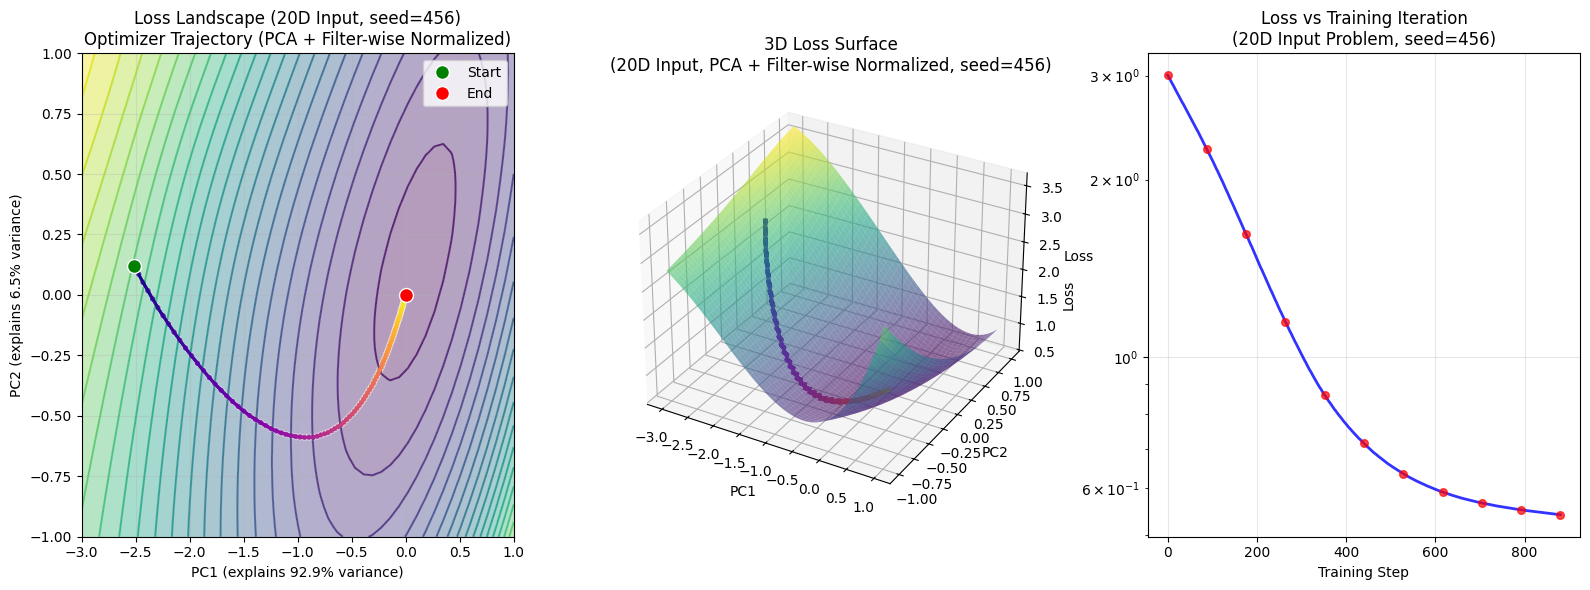


Visualization complete!
Seed used: 456
Model has 1,409 trainable parameters
Input dimensionality: 20
Initial loss: 3.005877
Final loss: 0.540594
Loss reduction: 5.6x
PCA captures 99.4% of trajectory variance
Trajectory length in 2D: 881 points


In [7]:
visualize_loss_landscape_with_trajectory(seed=456)

# For Flora Adam

In [8]:
from src.flora import FloraAdam

In [9]:
def train_and_record_trajectory(model, train_loader, epochs=100, lr=0.0001, seed=42):
    """Train model and record weight trajectory"""
    # Set seed for reproducible training
    set_seed(seed)

    criterion = nn.MSELoss()
    optimizer = FloraAdam(model.parameters(), lr=lr, rank = 8, kappa = 200)
    # Record initial weights
    weight_trajectory = []
    weight_trajectory.append([param.data.clone() for param in model.parameters() if param.requires_grad])

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Record weights every few batches for better PCA
            if batch_idx % 3 == 0:  # Record every 3 batches
                weight_trajectory.append([param.data.clone() for param in model.parameters() if param.requires_grad])

        # Print progress
        if (epoch + 1) % 20 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

    return weight_trajectory, criterion

In [10]:
def visualize_loss_landscape_with_trajectory(seed=42):
    """Main function to create loss landscape visualization with optimizer trajectory using PCA directions"""
    # Set global seed
    set_seed(seed)

    # Create model and data with 20-dimensional input
    model = SimpleMLP(input_size=20, hidden_size=64, output_size=1, seed=seed)
    train_loader = create_sample_data(n_samples=2000, input_dim=20, seed=seed)

    print(f"Using seed: {seed}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Train model and record trajectory
    print("Training model and recording trajectory...")
    weight_trajectory, criterion = train_and_record_trajectory(
        model, train_loader, epochs=80, seed=seed
    )
    print(f"Recorded {len(weight_trajectory)} weight snapshots during training")

    # Create visualizer
    visualizer = LossLandscapeVisualizer(model, criterion, train_loader)

    # Get final weights θn as center point (instead of initial weights)
    final_weights = weight_trajectory[-1]

    # Create a model with final weights for surface computation
    final_model = copy.deepcopy(model)
    idx = 0
    for param in final_model.parameters():
        if param.requires_grad:
            param.data = final_weights[idx]
            idx += 1

    # Create loss surface using PCA directions centered at θn
    print("Computing PCA directions from trajectory differences...")
    X, Y, Z, direction1, direction2, explained_variance = visualizer.create_loss_surface(
        final_model, weight_trajectory, x_range=(-3, 1), y_range=(-1, 1), resolution=50
    )

    # Project trajectory to 2D using PCA directions (relative to final weights)
    print("Projecting trajectory to PCA plane...")
    trajectory_2d = visualizer.project_trajectory_to_2d(
        weight_trajectory, final_weights, direction1, direction2
    )

    # Set seed for reproducible plotting colors
    set_seed(seed)

    # Create visualization
    fig = plt.figure(figsize=(16, 6))

    # 2D contour plot with trajectory
    ax1 = fig.add_subplot(131)
    contour = ax1.contour(X, Y, Z, levels=25, alpha=0.7)
    ax1.contourf(X, Y, Z, levels=25, alpha=0.4, cmap='viridis')

    # Color trajectory by time (from blue to red)
    n_points = len(trajectory_2d)
    colors = plt.cm.plasma(np.linspace(0, 1, n_points))

    for i in range(n_points-1):
        ax1.plot(trajectory_2d[i:i+2, 0], trajectory_2d[i:i+2, 1],
                color=colors[i], linewidth=2, alpha=0.8)

    ax1.scatter(trajectory_2d[::10, 0], trajectory_2d[::10, 1],
               c=np.arange(0, n_points, 10), cmap='plasma', s=20, alpha=0.7, edgecolors='white', linewidth=0.5)
    ax1.plot(trajectory_2d[0, 0], trajectory_2d[0, 1], 'go', markersize=10, label='Start', markeredgecolor='white')
    ax1.plot(trajectory_2d[-1, 0], trajectory_2d[-1, 1], 'ro', markersize=10, label='End', markeredgecolor='white')

    ax1.set_xlabel(f'PC1 (explains {explained_variance[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 (explains {explained_variance[1]:.1%} variance)')
    ax1.set_title(f'Loss Landscape (20D Input, seed={seed})\nOptimizer Trajectory (PCA + Filter-wise Normalized)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 3D surface plot
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(X, Y, Z, alpha=0.6, cmap='viridis', linewidth=0, antialiased=True)

    # Project trajectory to 3D (compute Z values for trajectory points)
    trajectory_z = []
    for point in trajectory_2d:
        # Find closest grid point for Z value
        i = np.argmin(np.abs(X[0, :] - point[0]))
        j = np.argmin(np.abs(Y[:, 0] - point[1]))
        trajectory_z.append(Z[j, i])

    # Plot trajectory with color gradient
    for i in range(len(trajectory_2d)-1):
        ax2.plot(trajectory_2d[i:i+2, 0], trajectory_2d[i:i+2, 1], trajectory_z[i:i+2],
                color=colors[i], linewidth=3, alpha=0.8)

    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('Loss')
    ax2.set_title(f'3D Loss Surface\n(20D Input, PCA + Filter-wise Normalized, seed={seed})')

    # Loss vs iteration
    ax3 = fig.add_subplot(133)

    # Compute actual loss trajectory
    loss_trajectory = []
    for weights in weight_trajectory:
        idx = 0
        for param in model.parameters():
            if param.requires_grad:
                param.data = weights[idx]
                idx += 1
        loss_trajectory.append(visualizer.compute_loss(model))

    ax3.plot(loss_trajectory, 'b-', linewidth=2, alpha=0.8)
    ax3.scatter(range(0, len(loss_trajectory), len(loss_trajectory)//10),
               loss_trajectory[::len(loss_trajectory)//10],
               c='red', s=30, alpha=0.7, zorder=5)
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('Loss')
    ax3.set_title(f'Loss vs Training Iteration\n(20D Input Problem, seed={seed})')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.savefig("plotFloraAdam.pdf", format="pdf")
    plt.show()

    print(f"\nVisualization complete!")
    print(f"Seed used: {seed}")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
    print(f"Input dimensionality: 20")
    print(f"Initial loss: {loss_trajectory[0]:.6f}")
    print(f"Final loss: {loss_trajectory[-1]:.6f}")
    print(f"Loss reduction: {loss_trajectory[0]/loss_trajectory[-1]:.1f}x")
    print(f"PCA captures {sum(explained_variance):.1%} of trajectory variance")
    print(f"Trajectory length in 2D: {len(trajectory_2d)} points")

Using seed: 456
Model parameters: 1,409
Training model and recording trajectory...
Epoch 20/80, Average Loss: 1.750936
Epoch 40/80, Average Loss: 1.017207
Epoch 60/80, Average Loss: 0.789602
Epoch 80/80, Average Loss: 0.662611
Recorded 881 weight snapshots during training
Computing PCA directions from trajectory differences...
Trajectory matrix shape: (880, 1409)
Mean trajectory difference norm: 1.2065
PCA explained variance: PC1=0.761, PC2=0.119
Projecting trajectory to PCA plane...


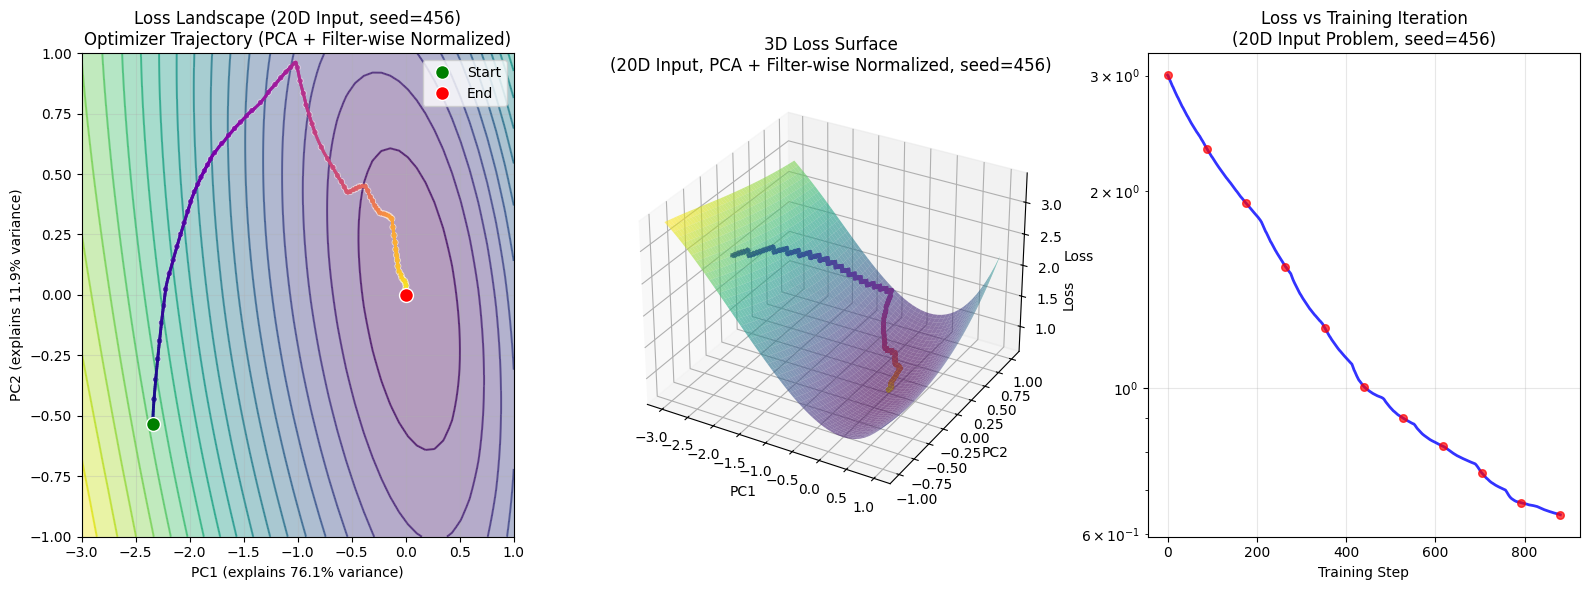


Visualization complete!
Seed used: 456
Model has 1,409 trainable parameters
Input dimensionality: 20
Initial loss: 3.005877
Final loss: 0.641733
Loss reduction: 4.7x
PCA captures 88.0% of trajectory variance
Trajectory length in 2D: 881 points


In [11]:
visualize_loss_landscape_with_trajectory(seed=456)